In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from pathlib import Path

import time
import math


## Function to calculate coefficients for a cell


In [2]:
def calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,implicit,v,i):
    #Lx,Ly : dimensions, Nx, Ny: cell numbers, shear: solid shear modulus, mu: fluid dynamic viscosity
    #rhof: fluid density, #cell: cell ID coefficients are being calculated for, #rho: density field
    #vis: viscosity/shear field, #D:smoothing coefficient field, implicit: Boolean, v: solution vector of current
    #iteration, i = eqs*cell ID
    
    #function that returns the harmonic mean of two number
    def harmonic_mean(x,y):
        return 2*x*y/(x+y)
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    eqs = 3
    
    #smoothing coefficient used in implicit and explicit so do first
    if (D[cell]!=D[cell+1]): #if FSI interface no smoothing
        D_e = 0
    else:
        D_e = harmonic_mean(D[cell],D[cell+1]) #D_east
        
    if (D[cell]!=D[cell-1]):
        D_w = 0
    else:
        D_w = harmonic_mean(D[cell],D[cell-1])#D_west
        
    if (D[cell]!=D[cell+Nx]):
        D_n = 0
    else:
        D_n = harmonic_mean(D[cell],D[cell+Nx])#D_north
    
    if (cell<Nx) or (D[cell]!=D[cell-Nx]): #do not compute for  bottom cell
        D_s = 0
    else:
        D_s = harmonic_mean(D[cell],D[cell-Nx]) #D_south
    
    if implicit == True: #compute coefficients to be inserted into coefficient matrix
        #MOMENTUM
        #Laplacian velocity
               #harmonic_mean(vis_P,vis_E)
        mu_e = harmonic_mean(vis[cell],vis[cell+1]) #returns viscoscity, shear or harmonic mean of viscosity and shear
        
        a_e = mu_e*dy/dx

        mu_w = harmonic_mean(vis[cell],vis[cell-1])
        a_w = mu_w*dy/dx 

        mu_n = harmonic_mean(vis[cell],vis[cell+Nx])
        a_n = mu_n*dx/dy
        
        a_s = 0 
        if cell>=Nx: #don't compute for bottom cells... this function is either called for an internal or a bottom
                                                    #cell, so do not want index error when called for a bottom
                                                    #cell. a_s=0 at bottom cell for fluid and solid
            mu_s = harmonic_mean(vis[cell],vis[cell-Nx])
            a_s = mu_s*dx/dy

        a_p = -(a_e+a_w+a_n+a_s)
        
        #Implicit pressure gradient
        Se = D_e*dy/dx
        
        Sw = D_w*dy/dx

        Sn = D_n*dx/dy
        
        Ss = D_s*dx/dy

        Sp = -(Se+Sw+Sn+Ss)
        gs=0
        
        #convection coefficients
        if rho[cell]==rhof:
            if (rho[cell]!=rho[cell+1]):
                ge = 0
            else:
                ge = -float(rhof*dy*(v[i+3]+v[i])/4) #Ae(vex+vpx)/4
            if (rho[cell]!=rho[cell-1]):
                gw = 0   
            else:
                gw = float(rhof*dy*(v[i-3]+v[i])/4) #-Aw(vwx+vpx)/4
            if (rho[cell]!=rho[cell+Nx]):
                gn = 0
            else:
                gn = -float(rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4) #An(vny+vpy)/4
            if (cell<Nx) or (rho[cell]!=rho[cell-Nx]): #again gs = 0 if for bottom cell
                gs = 0
            else:
                gs = float(rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4) #-As(vsy+vpy)/4
        else:
            ge = 0
            gw = 0
            gn = 0
            gs = 0
            
        gp = ge+gn+gw+gs
        coefficients = np.array([a_e,a_w,a_n,a_s,a_p,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp])
        return coefficients
    
    else:
        #explicit pressure gradient
        Re = D_e*dy/2
        
        Rw = D_w*dy/2
        
        Rn = D_n*dx/2
        
        Rs = D_s*dx/2
        
        coefficients = np.array([Re,Rw,Rn,Rs])
        
        return coefficients
    

Build solid block of with 1/50 th of the channel length (4mm for 200mm)  

In [3]:
def build_solid_block(Nx,Ny,height,pos): #height and pos percentages of channel length and height respectively
    width = int(1/50*Nx)
    height = math.floor(0.5*Ny) #height of block
    start = math.floor(Nx*pos)
    solid_cells = np.array(())
    for i in range(0,height): #solid block of width "width"
         #where block starts down channel
        solid_col = np.arange(start,start+width, 1)#build each column of solid cells
        solid_cells = np.append(solid_cells,solid_col)
        start +=Nx
    return solid_cells.astype(int)

## Build Coefficient Matrix

In [11]:
def assemble_matrix(Lx,Ly,Nx,Ny,mu,shear,dt, rhof, rhos,vin,scaleFactor, solid_cells,v):
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    # total number of cells
    
    M = int(Nx*Ny)
    
    #-----COEFFICIENTS----
    #X-MOM and Y_MOM
    #velocities
    #solid momentum coeffs
    axf = mu*dy/dx
    ayf = mu*dx/dy
    apf = -2*(axf+ayf)
    
    #solid momentum coeffs
    axs = dt*shear*dy/dx
    ays = dt*shear*dx/dy
    aps = -2*(axs+ays)
    
    #continuity equation
    Df = scaleFactor*dx*dy/apf
    Ds = scaleFactor*dx*dy/aps
    D_h = 2*Df*Ds/(Df+Ds)
    #LHS Pressure Gradient
    Sxf = (Df*dy)/dx
    Syf = (Df*dx)/dy
    Spf = -2*(Sxf+Syf)
    
    #pressures
    cx = dy/2
    cy = dx/2
    
    #Create material fields
    rho  = np.full(M,rhof)
    rho[solid_cells] = rhos #fluid or solid density
    
    vis = np.full(M,mu)
    vis[solid_cells] = shear*dt #shear or viscosity
    
    
    D = np.full(M,Df)
    D[solid_cells] = Ds #smoothing or viscosity
    
    eqs = 3 #3 equations (momentum x, y and continuity)
    
    #default alpha to be a fluid
    alpha = 1
    
    #Initialise coefficient matrix
    A = np.zeros((eqs*M, eqs*M))
     #Initialise source vector
    b = np.zeros((eqs*M, 1))
   
    internal = (Nx-2)*(Ny-2)
    top_wall = (Nx-2)
    fluid_cells_bot = Nx-2-4
    
    vertical_side = (Ny-2)
    numNonZeros = int(M*23) #23 is max number of coeffs and occurs for internal cells
    
    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))
    
    #indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #Loop through each cell i
    
    coeffi=0
    for i,cell in zip(range(0, eqs*M, eqs),range(0,M,1)):
        #set alpha to 1 at beginning of each iteration
        alpha=1
        
        if cell in solid_cells:#change alpha to zero if it is a solid cell
            alpha = 0
        
        #NOTE: "calculate_coefficients" only used in bottom and internal cells, as other cells do not have FSI interface
        #CORNERS
        #bottom left
        if i == 0:
            
            #calculate convection coefficients
            ge = -rhof*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gn = -rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4

            #X-MOM
            #-------#
            #RHS
            b[i] = -2*axf*vin[0]+dy*vin[0]**2*rhof
            #LHS
            
            #vpx
            data[coeffi] = apf-axf-ayf+ge+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = axf+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vnx
            data[coeffi] = ayf+gn 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            #Pp
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*axf*vin[1]+dy*vin[0]*vin[1]*rhof
            #LHS
            
            #vpy
            data[coeffi] = apf-axf-ayf+ge+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = axf+ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
            #LHS
            
            #vpx
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Spf/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
           
        #bottom right
        elif i == botright:
            gw = rhof*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -axf-3*ayf+gw+gn-dy*v[i]*rhof
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = axf+gw 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vnx
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -axf-3*ayf+gw+gn-dy*v[i]*rhof  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = axf+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vny
            data[coeffi] = ayf+gn 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
 
            #LHS
            
            #vpx
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sxf
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sxf-Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #Top Left
        elif i == topleft:
            
            ge = -rhof*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*axf*vin[0]+dy*rhof*vin[0]**2
            #LHS
            
            #vpx
            data[coeffi] = apf-axf-ayf+ge+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = axf+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*axf*vin[1]+dy*rhof*vin[0]*vin[1]
            #LHS
            
            #vpy
            data[coeffi] = apf-axf-ayf+ge+gs  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = axf+ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Spf/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
        #top right
        elif i == topright:
            
            gw = rhof*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -axf-3*ayf-rhof*dy*v[i]+gw+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = axf+gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*cx
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
               
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -axf-3*ayf-rhof*dy*v[i]+gw+gs 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = axf+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vsy
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vsx
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sxf
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sxf-Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            #coefficients[ae,aw,an,as,ap,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp]
            coefficients = calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,True,v,i)
            
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            #Don't add convection term if solid
            if alpha==1: #fluid
                data[coeffi] = coefficients[4]-2*ayf+coefficients[-5]+coefficients[-4]+coefficients[-3] #ap-as... *2 because a_s set to zero in functuion    
            else:
                data[coeffi] = coefficients[4]-2*ays
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = coefficients[1]+coefficients[-4] #aw+gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = coefficients[0]+coefficients[-5] #ae+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = coefficients[2]+coefficients[-3] #an+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = (1-alpha)*rhos*9.81*dx*dy
            #LHS
            if alpha==1:
                data[coeffi] = coefficients[4]-2*ayf+coefficients[-5]+coefficients[-4]+coefficients[-3] #ap-as... *2 because a_s set to zero in functuion
            else:
                data[coeffi] = coefficients[4]-2*ays
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = coefficients[1]+coefficients[-4] #aw  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = coefficients[0]+coefficients[-5] #ae  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = coefficients[2]+coefficients[-3] #an  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1

            data[coeffi] = -cy #Pn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2

            coeffi+=1

            data[coeffi] = cy #Pp
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2

            
            coeffi+=1
            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            if alpha == 1: #only add these if fluid cell as smoothing term blank for solid boundary
                #Pw
                data[coeffi] = coefficients[6]
                row_idx[coeffi] = i+2
                col_idx[coeffi] = i-1

                coeffi+=1

                #Pe
                data[coeffi] = coefficients[5]
                row_idx[coeffi] = i+2
                col_idx[coeffi] = i+5

                coeffi+=1

                #Pn
                data[coeffi] = coefficients[7]  
                row_idx[coeffi] = i+2
                col_idx[coeffi] = i+eqs*Nx+2

                coeffi+=1

                #Pp
                data[coeffi] = coefficients[9]#-Sp+Ss
                row_idx[coeffi] = i+2
                col_idx[coeffi] = i+2

                coeffi+=1
           
        #top
        elif topleft < i < topright:
            
            ge = -rhof*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gw = rhof*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = apf-ayf +ge+gw+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = axf+gw 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = axf+ge 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = apf-ayf+ge+gw+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = axf+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = axf+ge 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ayf+gs  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -2*Sxf-Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
            
            ge = -rhof*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gn = -rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*axf*vin[0]+rhof*dy*vin[0]**2
            #LHS
            
            #vpx
            data[coeffi] = -3*axf-2*ayf+ge+gn+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = axf+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ayf+gn 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*axf*vin[1]+rhof*dy*vin[0]*vin[1]
            #LHS
            #vpy
            data[coeffi] = -3*axf-2*ayf+ge+gn+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = axf+ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pn
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = cx 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Syf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -Sxf-2*Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gw = rhof*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -axf-2*ayf +gw+gn+gs-rhof*dy*v[i]   
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = axf+gw 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*cx 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
    
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -axf-2*ayf+gw+gn+gs-rhof*dy*v[i]  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = axf+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vny
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1

            
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = cx 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #smoothing off for outlet
#             #Pw
#             data[coeffi] = Sxf
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Syf
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = Sp-Sxf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
        else:
            #coefficients[ae,aw,an,as,ap,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp]
            coefficients = calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,True,v,i)
            
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = coefficients[4]+coefficients[-1]
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = coefficients[1]+coefficients[-4]
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = coefficients[0]+coefficients[-5]
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = coefficients[2]+coefficients[-3] 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = coefficients[3]+coefficients[-2]
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = cx 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -cx 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = (1-alpha)*rhos*9.81*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = coefficients[4]+coefficients[-1]
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = coefficients[1]+coefficients[-4]  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = coefficients[0]+coefficients[-5]
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = coefficients[2]+coefficients[-3]
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = coefficients[3]+coefficients[-2]
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#

            #LHS
            
            #vex
            data[coeffi] = cx 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #Pw
            data[coeffi] = coefficients[6]
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = coefficients[5]
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = coefficients[7]
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = coefficients[8]  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = coefficients[9]  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
#     print(coeffi,data[coeffi])
#     count = 0
#     B = np.zeros((eqs*M,eqs*M))
#     for i,j in zip(row_idx,col_idx):
#         B[int(i),int(j)] = data[count]
#         count+=1
    #compile coefficient matrix
    A = csr_matrix((data[0:coeffi+1], (row_idx[0:coeffi+1], col_idx[0:coeffi+1])), shape=(eqs*M,eqs*M))
    
    return A,b,rho,vis,D,Df
    





### Calculate Pressure Gradient of last iteration 


In [12]:

def calculate_gradients(Nx,Ny,Lx,Ly,v,solid_cells):
    
    dx = Lx/Nx
    dy = Ly/Ny
    eqs = 3 #3 equations (momentum x, y and continuity)
    # total number of cells
    M = int(Nx*Ny)
    
    gradP = np.zeros((2*M,1)) 
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    #Loop through each cell i
    for i,coeff,cell in zip(range(0, eqs*M, eqs),range(0,2*M,2),range(0,M,1)):
        #CORNERS
        #bottom left
        if i == 0:
            
            gradP[coeff]  = (v[i+5]-v[i+2])/(2*dx) # (1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
               
        #bottom right
        elif i == botright:
                        
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (PE-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
              
        elif i == topleft:
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dy
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #top right
        elif i == topright:
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            
            
            
        #top
        elif topleft < i < topright:
                        
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
           
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        else:
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
    

    return gradP

## Helper Functions



Map coordinates to cell centres

In [13]:
def map_cells_to_coordinates(Nx,Ny,Lx,Ly):
    dx  = Lx/Nx
    dy = Ly/Ny
    ycoord = np.arange(0,Ly+dy,dy, dtype=float)
    xcoord = np.arange(0,Lx+dx,dx, dtype=float)
    cells_to_coord = {}
    count = 0
    for y in ycoord:
        for x in xcoord:
            cells_to_coord[count] = '%f %f' %(x,y)
            count+=1
#                 f.write('%f %f 0.0 \n' %(x,y))
    return cells_to_coord

Get order of magnitude of a number

In [14]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))


Export solid results to VTK

In [15]:
def solid_vtk_results(v,disp,p,Nx,Ny,Lx,Ly,solid_cells,Re):
    
    dir_name = Path("VTK_results")
    dir_name.mkdir(parents=True, exist_ok=True)
    dx = Lx/Nx
    dy = Ly/Ny
    points_x = math.floor(1/50*Nx)+1
    
    points_y = math.floor(Ny/2)+1

    begin_x = float(cells_to_coord[solid_cells[0]].split()[0])
    begin_y = float(cells_to_coord[solid_cells[0]].split()[1])
    xcoord = np.arange(begin_x,begin_x+(points_x-1)*dx,dx)
    ycoord = np.arange(begin_y,begin_y+(points_y)*dy,dy)

    order_d = orderOfMagnitude(np.max(disp))
    order_p = orderOfMagnitude(p[0])
    disp = disp*10**-order_d
    v = v*10**-order_d
#     p = p*10**-order_p
    fname = 'solidRe=%fshear=1e%i.vtk'%(Re,orderOfMagnitude(shear))
    Nz = 1
    preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
    with open(dir_name/fname, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(points_x,points_y,Nz))
        f.write('POINTS %i float\n' %((points_x)*(points_y)))
        
        #inputs coordinates
        for y in ycoord:
            for x in xcoord:
                f.write('%f %f 0.0 \n' %(x,y))
                
        #input velocities
        f.write('CELL_DATA %i\n'%(len(solid_cells)))
        f.write('SCALARS DisplacementMagnitude(1e%im/s) float 1\nLOOKUP_TABLE default\n'%-order_d)
        for d in disp:
            f.write('%.8f\n'%(d))
        
        #input pressure
        f.write('SCALARS LeafletPressure(Pa) float 1\nLOOKUP_TABLE default\n')
        for pe in p:
            f.write('%.8f\n'%(pe))
        
#         #input velocity vectors
#         f.write('VECTORS Velocity(1e%im/s) float\n'%-order_d)
#         for i in range(0,len(v)-1,3):
#             f.write('%f %f 0\n'%(v[i],v[i+1]))


Export Fluid Results to VTK

In [23]:
def fluid_vtk_results(v,vmag,p,Nx,Ny,Lx,Ly,solid_cells,Re):
    
    dir_name = Path("VTK_results")
    dir_name.mkdir(parents=True, exist_ok=True)
    dx = Lx/Nx
    dy = Ly/Ny
    ycoord = np.arange(0,Ly+dy,dy, dtype=float)
    xcoord = np.arange(0,Lx+dx,dx, dtype=float)
    order_v = orderOfMagnitude(np.max(vmag))
#     order_p = orderOfMagnitude(p[0])
    vmag_copy = vmag
    vmag_copy[solid_cells] = 0
    p_copy = p
    p_copy[solid_cells] = 0
    vmag_copy = vmag*10**-order_v
    v = v*10**-order_v
#     p_copy = p_copy*10**-order_p
    fname = 'fluidRe=%.3ffshear=1e%i.vtk'%(Re,orderOfMagnitude(shear))
    Nz = 1
    preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
    with open(dir_name/fname, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(Nx+1,Ny+1,Nz))
        f.write('POINTS %i float\n' %((Nx+1)*(Ny+1)))
        count = 0
        
        #inputs coordinates
        for y in ycoord:
            for x in xcoord:
                f.write('%f %f 0.0 \n' %(x,y))
                
        #input velocities
        f.write('CELL_DATA %i\n'%((Nx)*(Ny)))
        f.write('SCALARS VelocityMagnitude(1e%im/s) float 1\nLOOKUP_TABLE default\n'%-order_v)
        for vel in vmag_copy:
            f.write('%.8f\n'%(vel))
        
        #input pressure
        f.write('SCALARS FluidPressure(Pa) float 1\nLOOKUP_TABLE default\n')
        for pe in p_copy:
            f.write('%.8f\n'%(pe))
        
        #input velocity vectors
        f.write('VECTORS Velocity(1e%im/s) float\n'%-order_v)
        for i in range(0,len(v)-1,3):
            f.write('%f %f 0\n'%(v[i],v[i+1]))

            

# Main Simulation


In [24]:

def FSI(Lx,Ly,Nx,Ny,mu,shear,dt,rhof,rhos, vin,scaleFactor,max_its,tol,vtk,solid_cells):
    

    # total number of cells
    M = int(Nx*Ny)
    #equations being solved
    eqs = 3
    
    #Initialise unknown vectors
    #Solution vector
    v = np.zeros((eqs*M, 1)) #results vector
    
    
    #get fluid smoothing coefficient
    _,_,_,_,_,Df = assemble_matrix(Lx,Ly,Nx,Ny,mu,shear,dt, rhof, rhos,vin,scaleFactor,solid_cells,v)
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    
    ycoord = np.arange(dy/2,Ly,dy, dtype=float)
    xcoord = np.arange(dx/2,Lx,dx, dtype=float)
    
    #coefficients
    #CONTINUITY
    #velocities
    ex = dy/2
    ey = dx/2
    
    #RHS Pressure Gradient
    Rx = (Df*dy)/2
    Ry = (Df*dx)/2
    
    
    vnew = np.zeros((eqs*M,1))
    
    #velocities and pressures
    vx = np.zeros((M, 1))#velocity x
    vxnew = np.zeros((M, 1)) #pressure
    vy = np.zeros((M, 1))#velocity y
    vynew = np.zeros((M, 1)) #pressure
    p = np.zeros((M, 1)) #pressure
    pnew = np.zeros((M, 1)) #pressure
    
    #displacements
    dispx = np.zeros((M,1))  #displacements x
    dispy = np.zeros((M,1)) #displacements y
    dispxold = np.zeros((M,1))  #old displacements x
    dispyold = np.zeros((M,1)) #old displacements y
    
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #list of residuals for each unknown
    residualsvx = []
    residualsvy = []
    residualsp = []
    init_resvx = 1
    init_resvy = 1
    init_resp = 1
    
    print('Iters, Residual vx, Residual vy, Residual p')
    
    for iterations in range(1,max_its+1):
        
        #calculate gradP for new iteration
        gradP = calculate_gradients(Nx,Ny,Lx,Ly,v,solid_cells)
        
        #build new coefficient matrix
        A,b,rho,vis,D,Df = assemble_matrix(Lx,Ly,Nx,Ny,mu,shear,dt, rhof, rhos,vin,scaleFactor,solid_cells,v)
        
        for i,coeff,cell in zip(range(0, eqs*M, eqs),range(0,2*M,2),range(0,M,1)):
            
            #CORNERS
            #bottom left
            if i == 0:
                #Rie-Chow
                #dy*vinx+re*dPe+rn*dPn+re*dPpx+rn*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff]*Rx+gradP[coeff+1]*Ry 
                                
            #bottom right
            elif i == botright:
                
                #-rw*dPw+rn*dPn+rn*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff+1]*Ry
            
            elif i == topleft:
                
                #re*dPe-rs*dPs+re*dPpx-rs*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx-gradP[coeff-2*Nx+1]*Ry+gradP[coeff]*Rx-gradP[coeff+1]*Ry
                
            #top right
            elif i == topright:
               #-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx-gradP[coeff-2*Nx+1]*Ry-gradP[coeff+1]*Ry

            #SIDES
            #bottom
            elif 0 < i < botright:
                #coefficients[ae,aw,an,as,ap,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp]
                coefficients = calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,False,v,i)
                
                if cell in solid_cells:
                    b[i+2]=0 #no smoothing term in solid
                else:
                    #re*dPe-rw*dpW+rn*dPn+rn*dPpy
                    b[i+2] = gradP[coeff+2]*coefficients[0]-gradP[coeff-2]*coefficients[1]+\
                    gradP[coeff+1]*coefficients[2]+gradP[coeff+2*Nx+1]*coefficients[2]
            
            #top
            elif topleft < i < topright:
                 
                #re*dPe-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx-gradP[coeff+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #left / Inlet
            elif i in range(eqs*Nx,topleft,eqs*Nx):
                
                #re*dPe+re*dPpx+rn*dPn-rs*dPs
                b[i+2] = 2*vin[0]*ex+gradP[coeff+2]*Rx+gradP[coeff]*Rx+gradP[coeff+2*Nx+1]*Ry -gradP[coeff-2*Nx+1]*Ry
            
            #right / Outlet
            elif i in range(botright+eqs*Nx,topright,eqs*Nx):
                
                #-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #internal
            else:
                ##coefficients[ae,aw,an,as,ap,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp]
                coefficients = calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,False,v,i)
                #re*dPe-rw*dPw+rn*dPn-rs*dPs
            
                b[i+2] = gradP[coeff+2]*coefficients[0]-gradP[coeff-2]*coefficients[1]\
                +gradP[coeff+2*Nx+1]*coefficients[2]-gradP[coeff-2*Nx+1]*coefficients[3]
        
        #solve system
        t = time.time()
        
        #solve system
        vnew = scipy.sparse.linalg.spsolve(A,b)

#         print("Time to solve system",time.time() - t)
        
        #get components of solution vector
        vxnew = vnew[0::3].reshape(M,1) #vx component
        vynew = vnew[1::3].reshape(M,1) #vy component
        pnew = vnew[2::3].reshape(M,1) #pressure component
        
        #calculate residuals
        resvx = np.linalg.norm(vxnew-vx)/init_resvx
        resvy = np.linalg.norm(vynew-vy)/init_resvy
        resp = np.linalg.norm(pnew-p)/(init_resp)
        
        #store residuals
        residualsvx.append(resvx)
        residualsvy.append(resvy)
        residualsp.append(resp)
        
        if (iterations==1):
            # Use a small number if the initial residual is small
            init_resvx = max(resvx, 1e-12)
            init_resvy = max(resvy, 1e-12)
            init_resp = max(resp, 1e-12)
            resvx = 1
            resvy = 1
            resp = 1
            
       
        #update solution
        vx = vxnew
        vy = vynew
        p = pnew
        v = vnew
        
        #update displacements
        dispx = dispxold+ vx*dt
        dispy = dispyold+vy*dt
        
        #print residuals
        print(iterations,resvx, resvy, resp)
        print('\n')
        
        #break loop if tolerance reached
        if (resvx < tol and resvy<tol and resp<tol):
            print("tolerance reached in %i iterations"%(iterations+1))
            break
            
    #end of time step update old values
    dispxold = dispx
    dispyold = dispy  
    
    #get velocity magnitude
    vmag = np.sqrt(np.square(vx)+np.square(vy))
    
    disp = (np.sqrt(np.square(dispx.reshape(M,1))+np.square(dispy.reshape(M,1))))

#     #get displacement
#     disp = vmag*dt
    
    #get pressure gradient from numerical answer
    pressure_gradient = np.mean(np.diff(p[int(0.5*Nx):]/dx,axis=0))
#     print(np.diff(vmag,axis=0))
    
    
    #PLOTTING
    X,Y = np.meshgrid(np.arange(0,Lx,dx),np.arange(0,Ly,dy))

    vmagplot = np.reshape(vmag, (Ny, Nx))#velocity plot
    pressure_plot = np.reshape(p,(Ny, Nx))#pressure plot
    
    #VELOCITY
    plt.figure(figsize=(18,3))
    plt.contourf(X,Y,vmagplot,cmap='inferno')
    plt.colorbar(label="Velocity (1e-i m/s)")
    plt.title("Velocity Magnitude Distribution", fontsize=15)
#     plt.savefig(dir_name/"VmagPvcoupling")
    
    #PRESSURE
    plt.figure(figsize=(18,3))
    plt.contourf(X,Y,pressure_plot,cmap='inferno')
    plt.colorbar(label="Pressure (1e Pa)")
    plt.title("Pressure Distribution",fontsize=15)
#     plt.savefig(dir_name/"PressureShear1e%i.png"%(orderOfMagnitude(shear)))
    

    #Print the Reynolds Number
    Re = vin[0] * Ly *rhof/mu
    print("Reynolds Number =", Re)
    print("Maximum Velocity", np.max(vmag))
    print("Maximum Pressure", np.max(p))
    print("avg solid disp",np.mean(disp[solid_cells]))
    print("max solid disp",np.max(disp[solid_cells]))
    #Run the Analytical solution for these parameters
    
    #convert lists to arrays
    residualsvx = np.array(residualsvx)
    residualsvy = np.array(residualsvy)
    residualsp = np.array(residualsp)
    residuals = np.zeros((iterations,3))
    residuals[:,0] = residualsvx
    residuals[:,1] = residualsvy
    residuals[:,2] = residualsp

#     print(p[Nx])
    #export to VTK format
    if vtk:
        solid_vtk_results(v,dt*vmag[solid_cells],p[solid_cells],Nx,Ny,Lx,Ly,solid_cells,Re)
        fluid_vtk_results(v,vmag,p,Nx,Ny,Lx,Ly,solid_cells,Re)        
    return v,iterations,residuals



## Run Code

Iters, Residual vx, Residual vy, Residual p
1 1 1 1


2 0.19330657599593287 0.02590735899846805 0.014967160191107717


3 0.009895791688667674 0.0012130058337933866 0.002256835178605026


4 0.0008581567766123053 0.0001441513493106509 0.00042786816024270553


5 0.00014265685599738526 3.1971989103100764e-05 9.00750084366933e-05


6 2.7857244509909503e-05 8.264635218763661e-06 2.0303099008706434e-05


7 6.7017863957892e-06 2.6741159025932354e-06 4.821867149146065e-06


8 1.5350475307780819e-06 7.339013466184849e-07 1.2569728597862692e-06


9 2.666965234147715e-06 1.2960014038440665e-06 7.571757383498609e-07


10 2.0497296323557415e-06 1.2310972540988821e-06 8.363345732595925e-07


11 1.5885123590405805e-06 1.3251235875952295e-06 1.3592610053141446e-06


12 2.3932953441569417e-06 1.2027117826299646e-06 3.157909306011698e-07


13 1.5830074934401519e-06 7.822866470681133e-07 4.340349658386009e-07


14 1.9323646859600018e-06 9.815261208045578e-07 3.018673238478595e-07


15 8.242915126483706e-0

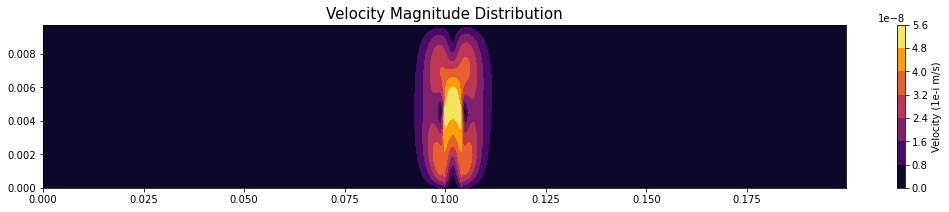

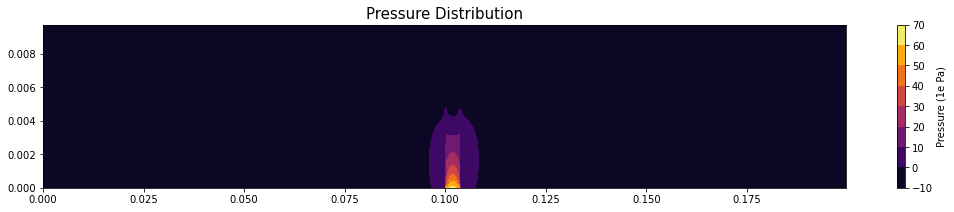

In [26]:
#DIMENSIONS
Lx = 0.2 #length channel x domain
Ly = 0.01 #length ch annel y domain
Nx =800 #number of cells in x domain
dx = Lx/Nx #cell length in x direction
Ny = 40 #number of cells in y direction
M = int(Nx*Ny) #total number of cells
dy = Ly/Ny#cell length in x direction


#solid block
pos = 0.5 #front face of solid block place (pos*Lx)m downstream of inlet
height = 0.5 #height of solid block (height*Ly)m high

solid_cells = build_solid_block(Nx,Ny,height,pos) #call function to build solid block and assign cell IDS

ycoord = np.arange(dy/2,Ly,dy, dtype=float) #cell centre coordinates
xcoord = np.arange(dx/2,Lx,dx, dtype=float)

#MATERIAL PROPERTIES
rhof = 1050 #fluid density
rhos = 1102 #solid density

mu = 3.5e-3 #fluid dynamic viscosity
shear = 1e6 #solid shear modulus

#OTHER PARAMETERS
max_its = 15#max iterations
tol = 1e-15 #residual tolerance
dt = 1 #time step
vin = np.array([0,0]) #input velocity
scaleFactor = 1 #smoothing coefficient scaling
vtk = True #export results to VTK foramat


cells_to_coord = map_cells_to_coordinates(Nx,Ny,Lx,Ly) #Map cells to coordinates
coord_to_cells = {v: k for k, v in cells_to_coord.items()} #map coordinates to cell IDs

v,iterations,residuals = FSI(Lx,Ly,Nx,Ny,mu,shear,dt,rhof,rhos, vin,scaleFactor,max_its,tol,vtk,solid_cells)

vmag = np.sqrt(np.square(v[0::3].reshape(M,1))+np.square(v[1::3].reshape(M,1))) #get the velocity magnitude
p = v[2::3].reshape(M,1) #get pressure from solution
max_disp = np.max(vmag[solid_cells]*dt) #get the maximum displacmeent
max_v = np.max(vmag) #get the maximum velocity
max_p = np.max(p) #get the maximum pressure
Re = vin[0] * Ly *rhof/mu #calculate the Reynolds number
disp = vmag[solid_cells]*dt

## Saved solution for Re=0.003, shear=1e6, cells = 800x40

In [ ]:
v_stokes = np.genfromtxt('solution_stokes_32kcells.csv')
vmag_stokes = np.sqrt(np.square(v_stokes[0::3].reshape(M,1))+np.square(v_stokes[1::3].reshape(M,1))) #get the velocity magnitude
p_stokes = v[2::3].reshape(M,1) #get pressure from solution
max_disp_stokes = np.max(vmag_stokes[solid_cells]*dt) #get the maximum displacmeent
max_v_stokes = np.max(vmag_stokes) #get the maximum velocity
max_p_stokes = np.max(p_stokes) #get the maximum pressure
disp_stokes = vmag_stokes[solid_cells]*dt #define displacement of leaflet
Re_stokes = vin[0] * Ly *rhof/mu #calculate the Reynolds number

## Saved solution for Re=300, shear=1e6, cells = 800x40

In [120]:
v_conv = np.genfromtxt('solution_conv_32kcells.csv')
vx_conv = v_conv[0::3].reshape(M,1)
vmag_conv = np.sqrt(np.square(v_conv[0::3].reshape(M,1))+np.square(v_conv[1::3].reshape(M,1))) #get the velocity magnitude
p_conv = v_conv[2::3].reshape(M,1) #get pressure from solution
max_disp_conv = np.max(vmag[solid_cells]*dt) #get the maximum displacmeent
max_v_conv = np.max(vmag) #get the maximum velocity
max_p_conv = np.max(p) #get the maximum pressure
disp_conv = vmag[solid_cells]*dt #define displacement of leaflet
Re_conv = vin[0] * Ly *rhof/mu #calculate the Reynolds number

# Gather Results

## Fluid Velocity

In [63]:
dir_name = Path("Report Stokes results")
dir_name.mkdir(parents=True, exist_ok=True)

Velocity across cross section, Lx*per_cent m downstream of channel

In [64]:
def free_stream_section(vmag, per_cent, Nx, Ny): #per_cent is where to cut the cross section
    
    bot = math.ceil(Nx*per_cent) #middle cell bottom of block
    top = bot+int(Nx*Ny)#middle cell top of block
    cells = np.arange(bot,top,Nx)#cells along middle of block
    vel_free = vmag[cells]
    vel_free = np.insert(vel_free, 0, 0, axis=None)
    vel_free = np.insert(vel_free, len(vel_free), 0, axis=None)
    return vel_free

#### Ansys vs python, velocity across cross section 0.05m downstream of inlet

In [65]:
ansys_velstokes05 =np.loadtxt("AnsysResults/vmag05.csv",delimiter=",", dtype=float)
per_cent = 0.25
python_vel05stokes = free_stream_section(vmag_stokes, per_cent, Nx, Ny)

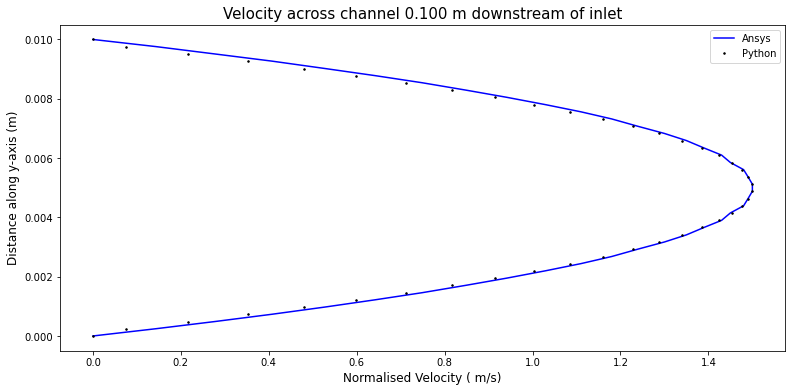

In [100]:
plt.figure(figsize=(13,6))
plt.plot(ansys_velstokes05[:,1]*1e6, ansys_velstokes05[:,0], 'b', python_vel05stokes*1e6,ansys_velstokes05[:,0],'ko', markersize = 1.5)
plt.title('Velocity across channel %.3f m downstream of inlet'%(Lx*per_cent), fontsize = 15, weight = 500)
plt.ylabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.xlabel('Normalised Velocity ( m/s)', fontsize = 12, weight = 500)
plt.legend(['Ansys', 'Python'])
plt.savefig(dir_name/"vmid05stokes")

#### Ansys vs python, velocity across cross section 0.1m downstream of inlet

In [101]:
ansys_velstokes1 =np.loadtxt("AnsysResults/vmag1.csv",delimiter=",", dtype=float)
per_cent = 0.5
python_vel1stokes = free_stream_section(vmag_stokes, per_cent, Nx, Ny)

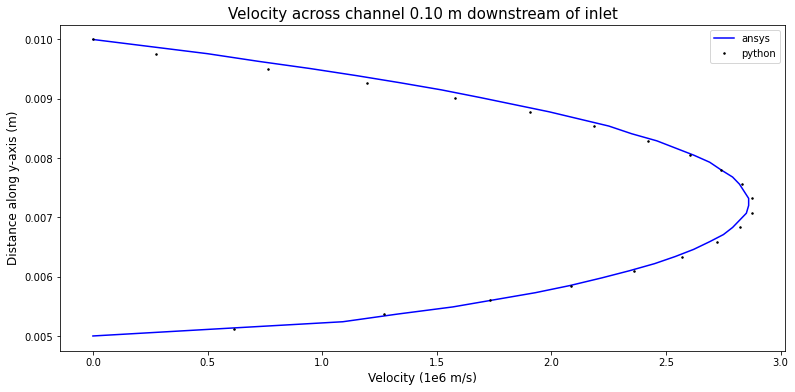

In [102]:
plt.figure(figsize = (13,6))
plt.plot(ansys_velstokes1[:,1]*1e6, ansys_velstokes1[:,0], 'b',python_vel1stokes[21:]*1e6,ansys_velstokes05[21:,0], 'ko', markersize = 1.5)
plt.title('Velocity across channel %.2f m downstream of inlet'%(Lx*per_cent), fontsize = 15, weight = 500)
plt.ylabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.xlabel('Velocity (1e6 m/s)', fontsize = 12, weight = 500)
plt.legend(['ansys', 'python'])
plt.savefig(dir_name/"vmid1stokes")

#### Ansys vs python, velocity across cross section 0.15m downstream of inlet

In [81]:
ansys_velstokes15 =np.loadtxt("AnsysResults/vmag15.csv",delimiter=",", dtype=float)
per_cent = 0.75
python_vel15stokes = free_stream_section(vmag_stokes, per_cent, Nx, Ny)

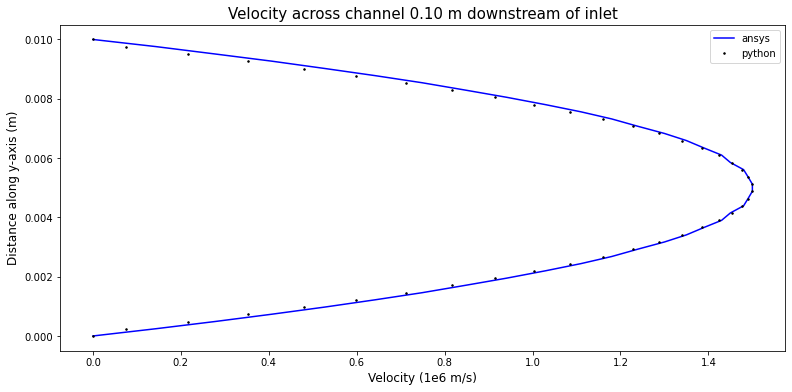

In [103]:
plt.figure(figsize = (13,6))
plt.plot(ansys_velstokes15[:,1]*1e6, ansys_velstokes15[:,0], 'b',python_vel15stokes*1e6,ansys_velstokes15[:,0], 'ko', markersize = 1.5)
plt.title('Velocity across channel %.2f m downstream of inlet'%(Lx*per_cent), fontsize = 15, weight = 500)
plt.ylabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.xlabel('Velocity (1e6 m/s)', fontsize = 12, weight = 500)
plt.legend(['ansys', 'python'])
plt.savefig(dir_name/"vmid15stokes")

## Pressure 

pressure across channel in x direction, 3/4 of height

In [104]:
def PmidChannel(p,Nx,Ny):
    
    
    left = math.floor((3*Ny/4))*Nx
    cells = np.arange(left,left+Nx)
    pmiddle = p[cells]
    pmiddle = np.insert(pmiddle, len(pmiddle), 0, axis=None)
    return pmiddle
    

In [84]:
ansys_p_stokes =np.loadtxt("AnsysResults/pmid00525.csv",delimiter=",", dtype=float)
python_p_stokes = PmidChannel(p_stokes,Nx,Ny)
ansys_p_stokes[-15:-1,1] =  python_p_stokes[-15:-1]


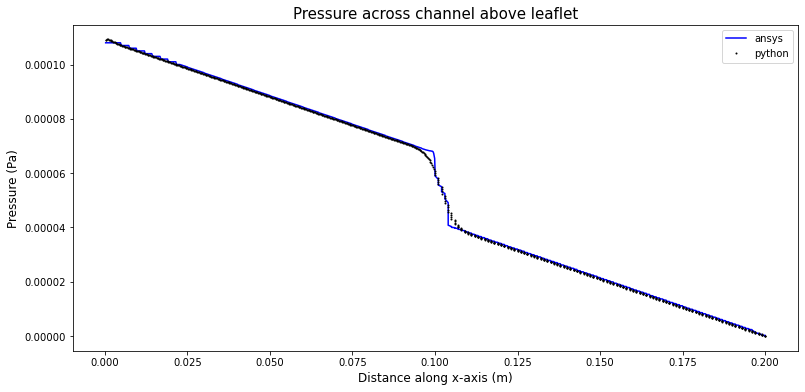

In [105]:
plt.figure(figsize=(13,6))
plt.plot(ansys_p_stokes[1:,0],ansys_p_stokes[1:,1], 'b',ansys_p_stokes[1:,0], python_p_stokes,'ko', markersize = 1)
plt.title('Pressure across channel above leaflet', fontsize = 15, weight = 500)
plt.xlabel('Distance along x-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Pressure (Pa)', fontsize = 12, weight = 500)
plt.legend(['ansys', 'python'])
plt.savefig(dir_name/"pmidstokes")

## Solid Deformation

In [100]:
def def_disp_line(disp, Nx,Ny): #per_cent is where to cut the cross section
    bot = coord_to_cells["0.120000 0.000000"]
    top = coord_to_cells["0.120000 0.004750"]
    top = math.floor(Nx/2+Ny/2*Nx)-1 #top solid cell 
    bot = math.floor(Nx/2)
    half_way = int((1/50*Nx)/2)
    cells = np.arange(bot+half_way,top+half_way,Nx)#cells along middle of block
    disp_y = vmag[cells]
    return disp_y

In [101]:
disp_y = def_disp_line(disp, Nx,Ny)

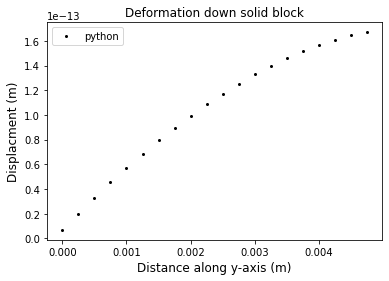

In [104]:
plt.figure()
plt.plot(np.arange(0,0.004750+dy,dy), disp_y, 'ko',markersize = 2)
plt.title('Deformation down solid block', fontsize = 12, weight = 500)
plt.xlabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Displacment (m)', fontsize = 12, weight = 500)
plt.legend(['python', 'ansys'])


# Results Convective past rigid leaflet

## Fluid Velocity

In [106]:
dir_name = Path("Report Convection results")
dir_name.mkdir(parents=True, exist_ok=True)

#### Ansys vs python, velocity across cross section 0.05m downstream of inlet

In [86]:
ansys_vel_conv05 =np.loadtxt("AnsysResults/vmid05conv.csv",delimiter=",", dtype=float)
per_cent = 0.25
python_vel05conv = free_stream_section(vmag_conv, per_cent, Nx, Ny)

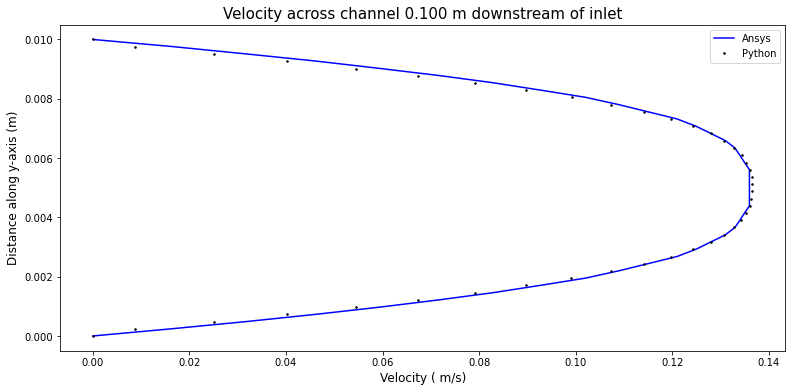

In [107]:
plt.figure(figsize=(13,6))
plt.plot(ansys_vel_conv05[:,1], ansys_vel_conv05[:,0], 'b', python_vel05conv,ansys_vel_conv05[:,0],'ko', markersize = 1.5)
plt.title('Velocity across channel %.3f m downstream of inlet'%(Lx*per_cent), fontsize = 15, weight = 500)
plt.ylabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.xlabel('Velocity ( m/s)', fontsize = 12, weight = 500)
plt.legend(['Ansys', 'Python'])
plt.savefig(dir_name/"vmid05conv")

#### Ansys vs python, velocity across cross section 0.1m downstream of inlet

In [90]:
ansys_vel_conv1 =np.loadtxt("AnsysResults/vmid1conv.csv",delimiter=",", dtype=float)
per_cent = 0.5
python_vel1_conv = free_stream_section(vmag_conv, per_cent, Nx, Ny)

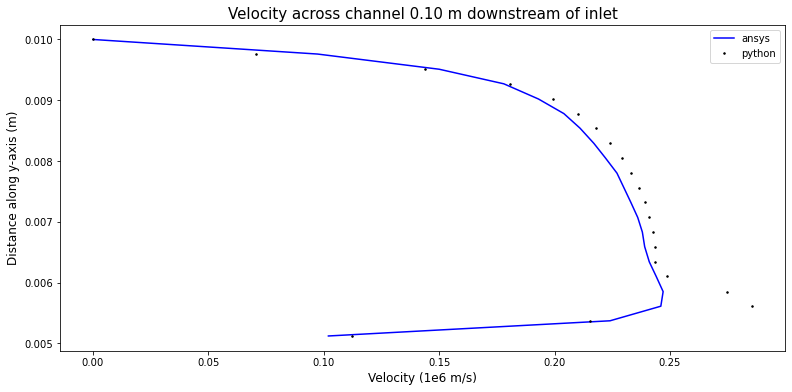

In [109]:
plt.figure(figsize = (13,6))
plt.plot(ansys_vel_conv1[21:,1], ansys_vel_conv1[21:,0], 'b',python_vel1_conv[21:],ansys_vel_conv05[21:,0], 'ko', markersize = 1.5)
plt.title('Velocity across channel %.2f m downstream of inlet'%(Lx*per_cent), fontsize = 15, weight = 500)
plt.ylabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.xlabel('Velocity (1e6 m/s)', fontsize = 12, weight = 500)
plt.legend(['ansys', 'python'])
plt.savefig(dir_name/"vmid1conv")

#### Ansys vs python, velocity across cross section 0.15m downstream of inlet

In [112]:
ansys_vel15_conv =np.loadtxt("AnsysResults/vx15conv.csv",delimiter=",", dtype=float)
per_cent = 0.75
python_vel15_conv = free_stream_section(vx_conv, per_cent, Nx, Ny)

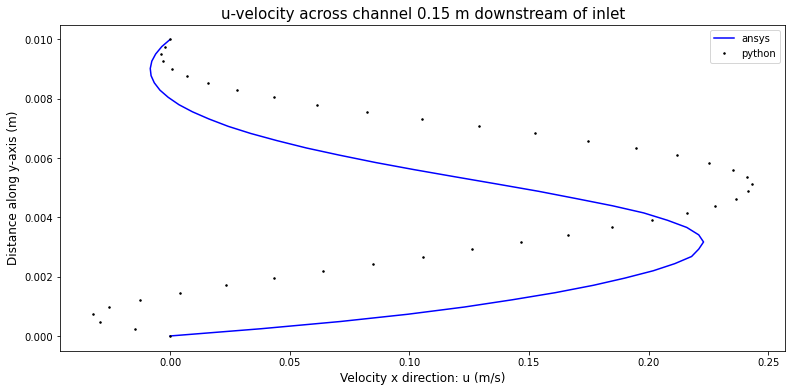

In [125]:
plt.figure(figsize = (13,6))
plt.plot(ansys_vel15_conv[:,1], ansys_vel15_conv[:,0], 'b',python_vel15_conv,ansys_vel15_conv[:,0], 'ko', markersize = 1.5)
plt.title('u-velocity across channel %.2f m downstream of inlet'%(Lx*per_cent), fontsize = 15, weight = 500)
plt.ylabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.xlabel('Velocity x direction: u (m/s)', fontsize = 12, weight = 500)
plt.legend(['ansys', 'python'])
plt.savefig(dir_name/"vmid15")

## Pressure 

In [121]:
ansys_p_conv =np.loadtxt("AnsysResults/pmid00525conv.csv",delimiter=",", dtype=float)
python_p_conv = PmidChannel(p_conv,Nx,Ny)
# ansys_p_conv[-15:-1,1] =  python_p_conv[-15:-1]


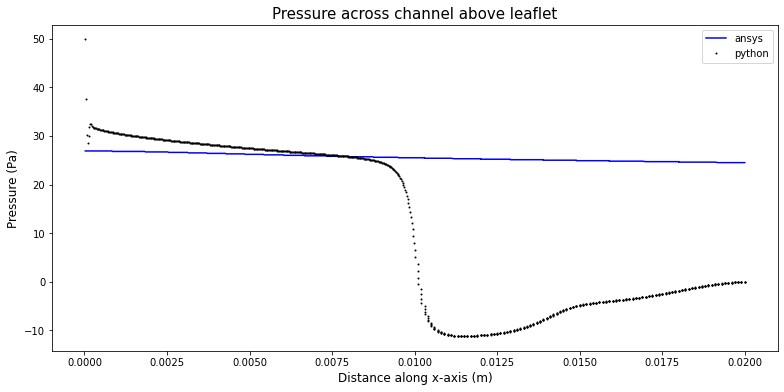

In [122]:
plt.figure(figsize=(13,6))
plt.plot(ansys_p_conv[1:,0],ansys_p_conv[1:,1], 'b',ansys_p_conv[1:,0], python_p_conv,'ko', markersize = 1)
plt.title('Pressure across channel above leaflet', fontsize = 15, weight = 500)
plt.xlabel('Distance along x-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Pressure (Pa)', fontsize = 12, weight = 500)
plt.legend(['ansys', 'python'])
plt.savefig(dir_name/"pmid")

## Solid Deformation

In [100]:
def def_disp_line(disp, Nx,Ny): #per_cent is where to cut the cross section
    bot = coord_to_cells["0.120000 0.000000"]
    top = coord_to_cells["0.120000 0.004750"]
    top = math.floor(Nx/2+Ny/2*Nx)-1 #top solid cell 
    bot = math.floor(Nx/2)
    half_way = int((1/50*Nx)/2)
    cells = np.arange(bot+half_way,top+half_way,Nx)#cells along middle of block
    disp_y = vmag[cells]
    return disp_y

In [101]:
disp_y = def_disp_line(disp, Nx,Ny)

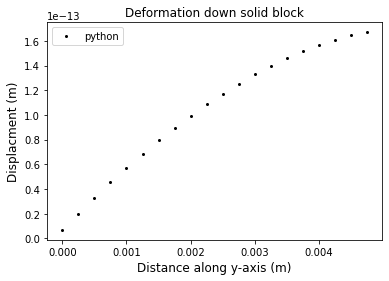

In [104]:
plt.figure()
plt.plot(np.arange(0,0.004750+dy,dy), disp_y, 'ko',markersize = 2)
plt.title('Deformation down solid block', fontsize = 12, weight = 500)
plt.xlabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Displacment (m)', fontsize = 12, weight = 500)
plt.legend(['python', 'ansys'])


In [105]:

def plot_residuals(residuals,iterations):
    
    residualsvx=residuals[:,0]
    residualsvy=residuals[:,1]
    residualsp=residuals[:,2]
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    iters_array = np.arange(1,iterations+1)

    ax1.plot(iters_array,residualsvx, 'b',iters_array,residualsvy, 'k',iters_array,residualsp,'r', marker = 'o',markersize = 1)
    fig.legend(['u', 'v','p'],bbox_to_anchor=(0.75, 0.55))
    fig.suptitle('Residual error of u,v,p versus iterations (dt =%.2f )'%dt, fontsize = 12, weight = 500)
    ax1.set_xlabel('Number of Iterations', fontsize = 12, weight = 500)
    plt.yscale('log')
    ax1.set_ylabel('Normalised Residual Error', fontsize = 12, weight = 500)
    plt.savefig('residualsdt=%.2f.png'%dt)

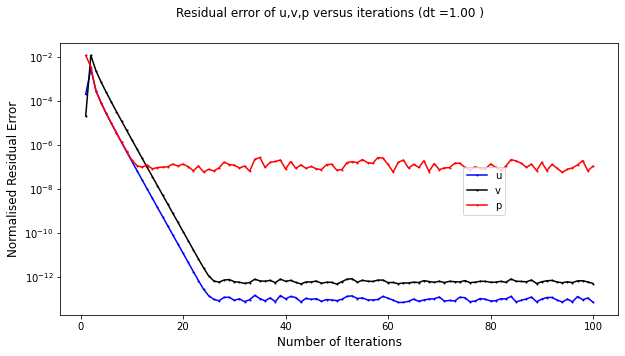

In [106]:
plot_residuals(residuals,iterations)